# Nuoseklių sakinių klasifikavimas atsitiktinių imčių medicininių tyrimų santraukose

---

## Santrauka

**Tikslas:** sukurti natūralios kalbos apdorojimo (*angl. Natural Language Processing*, **NLP**) modelį, kuris palengvintų medicininių tyrimų publikacijų santraukų skaitymą.

**Metodai:**
- teksto vektorizacija
- scikit-learn modelio kūrimas
- Google TensorFlow modelių kūrimas

**Rezultatas:** TODO

**Išvada:** TODO

### Bibliotekų importavimas

In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [89]:
# išjungiam TensorFlow įspėjimų (warnings) vaizdavimą rezultatuose
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Įvadas

Kiekvienais metais publikuojamų medicininių tyrimų skaičius tik auga, todėl medicinos specialistams tampa vis sunkiau greitai aptikti jiems reikiamą informaciją. Tyrinėtojai nagrinėdami ankstesnes publikacijas, dažniausiai perskaito tik santraukas, norėdami greitai patikrinti, ar straipsniai atitinka jų kriterijus. Šis procesas yra lengvesnis ir greitesnis jei santrauka yra **struktūrizuota**, t.y. padalinima į semantines antraštes (etikėtes), tokias kaip **tikslas, metodas, rezultatas ir išvada**. 

Kiekvieno santraukos sakinio suskirstymas į atitinkamą antraštę vadinamas nuoseklių sakinių klasifikavimu. Šiai  užduočiai atlikti šiame darbe įgyvendinama dirbtinio neuroninio tinklo (*angl. artificial neural network*, **ANN**) modeliu pagrįsta sistema.

Darbas atliekamas remiantis **Franck Dernoncourt**, **Ji Young Lee** ir **Peter Szolovits** 2017 metų publikacija "[**Neural Networks for Joint Sentence Classification in Medical Paper Abstracts**](https://arxiv.org/pdf/1612.05251)".

Neuroninių modelių kūrimui naudojama atviro kodo mašininio mokymo ir dirbtinio intelekto biblioteka [**Google TensorFlow**](https://www.tensorflow.org/).

---

## Duomenų rinkinys (*angl. dataset*)


[**PubMed 200k RCT**](https://arxiv.org/pdf/1710.06071.pdf) duomenų rinkinys sudaryta iš viešai prieinamos bibliotekos [PubMed](https://pubmed.ncbi.nlm.nih.gov/) įrašų ir yra skirtas nuosekliam sakinių klasifikavimui atsitiktinės imties kontroliuojamų medicininių tyrimų santraukose. Duomenų rinkinys susideda iš ~200 tūkst. santraukų, kurias sudaro apie  2,3 mln. sakinių.

Kiekvienas sakinys yra pažymėtas etikėte, nurodančia sakinio reikšmę santraukoje:
- **background** - kilmė, ištakos
- **objective** - tikslas
- **methods** - metodai
- **results** - rezultatai
- **conclusions** - išvados

Rinkinys yra viešai prieinamas [**GitHub repozitorijoje**](https://github.com/Franck-Dernoncourt/pubmed-rct)

### Atsiuntimas

In [90]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


### Struktūra

In [91]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Pagrindinis duomenų rinkinys **PubMed 200k RCT** kai kuriais atvejais gali būti per didelis, todėl papildomai yra pateikiamas **PubMed 20k RCT** rinkinys, sudarytas iš 10% pagrindiniame rinkinyje esančių vėliausiai publikuotų tyrimų santraukų.

Šalia duomenų rinkinių su originaliu tekstu, pateikiamos versijos, kuriose santraukų tekste esantys skaičiai pakeisti @ simboliu.

In [92]:
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [93]:
!ls pubmed-rct/PubMed_200k_RCT/

dev.txt  test.txt  train.7z


Rinkinio aplankuose yra po tris failus:
- **train.txt** (**train.7z**) - mokymo santraukų rinkinys,
- **test.txt** - testavimo santraukų rinkinys,
- **dev.txt** - modelio įvertinimo (*angl. validation*) rinkinys.

### Failo formatas

In [94]:
def get_all_lines(filename: str) -> list:
    """
    Grąžina nuskaityto tekstinio failo  filename  eilutes string sąraše
    """

    with open(filename, "r") as f:
        return f.readlines()

Kiekvienas failas turi tą patį formatą:
- **PMID eilutė** - santraukos pradžia, publikacijos *identifikavimo numeris PubMed* bibliotekoje;
- **santraukos sakiniai** atskirose eilutėse, kiekvienos pradžioje didžiosiomis raidėmis sakinio etiketė ir santraukos sakinio tekstas atskirti tabuliacijos simboliu (*angl. tab*);
- **tuščia eilutė** - santraukos pabaiga.


In [95]:
FOLDER_PATH = "pubmed-rct/PubMed_20k_RCT/"

filename = os.path.join(FOLDER_PATH, "test.txt")
file_lines = get_all_lines(filename)

# išvedam 20 pirmų failo eilučių
file_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin 23.8 % , aspartate transaminase 23.5 % , alanine transaminase 23.8 % , and total bilirubin 36.1 % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to 6-months ' follow-u

### Duomenų formato keitimas

Patogesniam darbui su duomenų rinkiniu, perkelsime duomenys į **pandas DataFrame**.

Tarpiniam formatui naudosim python žodyną:
- **number** - sakinio numeris santraukoje
- **target** - sakinio etiketė
- **text**   - sakinio tekstas
- **total**  - visų santraukoje esančių sakinių skaičius

```
[{'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
  'number': 0,
  'total': 9},
 {...},
]
```

In [96]:
def convert_file_lines_to_dic(filename: str) -> list:
    """
    Grąžina faile  filename  esančių santraukų skaičių ir sakinių žodynų sąrašą.
    Sakinio žodynas papildomas eilės numeriu ir visų santraukos sakinių skaičiumi.
    """
        
    all_lines = get_all_lines(filename) #nuskaitom visas faile esančias eilutes
    abstract_count = 0
    list_of_dicts = []

    for line in all_lines:
        if line.startswith("###"):  #tikrinam ar eilutė prasideda simboliais ### (santraukos pradžia)
            abstract = ''           
            abstract_count += 1

        elif line.isspace():        #tikrinam ar eilutė yra tuščia (santraukos pabaiga)
            abstract_lines = abstract.splitlines()
            total = len(abstract_lines)

            
            for i, sentence in enumerate(abstract_lines):
                sentence_parts = sentence.split('\t')   #[0] etiketė, [1] tekstas

                sentence_dict = {}

                sentence_dict['target'] = sentence_parts[0]
                sentence_dict['text'] = sentence_parts[1]
                sentence_dict['number'] = i
                sentence_dict['total'] = total
                
                list_of_dicts.append(sentence_dict)
       
        else:                       #pridedam eilutę prie kitų santraukos eilučių
            abstract += line
    
    return abstract_count, list_of_dicts

In [97]:
# perkeliam duomenų rinkinio failų santraukų sakinius į žodynų sąrašus
DATASET_PATH = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

train_abstract_count, train_dicts = convert_file_lines_to_dic(DATASET_PATH + 'train.txt')
test_abstract_count, test_dicts = convert_file_lines_to_dic(DATASET_PATH + 'test.txt')
val_abstract_count, val_dicts = convert_file_lines_to_dic(DATASET_PATH + 'dev.txt')

In [98]:
# išvedam pirmus penkis train.txt faile esančius sakinius žodyno pavidalu
train_dicts[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'number': 0,
  'total': 12},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'number': 1,
  'total': 12},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'number': 2,
  'total': 12},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'number': 3,
  'total': 12},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis I

Nauju formatu turimus duomenys galime lengvai perkelti į pandas DataFrame.

In [99]:
train_df = pd.DataFrame(train_dicts)
test_df = pd.DataFrame(test_dicts)
val_df = pd.DataFrame(val_dicts)

In [100]:
train_df.head()

,target,text,number,total
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,METHODS,Outcome measures included pain reduction and i...,2,12
3,METHODS,Pain was assessed using the visual analog pain...,3,12
4,METHODS,Secondary outcome measures included the Wester...,4,12


### Duomenų rinkinių analizė ir vizualizavimas

Bazinio ir pradinių modelių sudarymui naudosime 10% pavyzdžių rinkinį **PubMed_20k_RCT_numbers_replaced_with_at_sign**.

In [101]:
print("Santraukų skaičius:")
print(f"\ttrain - {train_abstract_count}")
print(f"\ttest - {test_abstract_count}")
print(f"\tval - {val_abstract_count}")

print("\nSakinių skaičius:")
print(f"\ttrain - {train_df.shape[0]}")
print(f"\ttest - {test_df.shape[0]}")
print(f"\tval - {val_df.shape[0]}")

print(f"\nIš viso:")
print(f"\tSantraukų: {train_abstract_count + test_abstract_count + val_abstract_count}")
print(f"\tSakinių: {train_df.shape[0] + test_df.shape[0] + val_df.shape[0]}")

Santraukų skaičius:
	train - 15000
	test - 2500
	val - 2500

Sakinių skaičius:
	train - 180040
	test - 30135
	val - 30212

Iš viso:
	Santraukų: 20000
	Sakinių: 240387


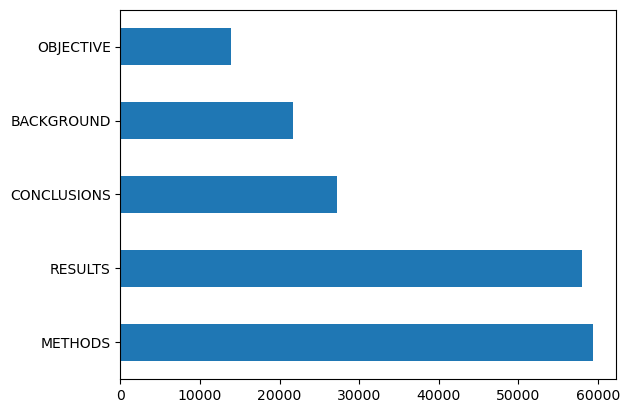

In [102]:
# sakinio etikečių pasiskirtymas train rinkinyje
train_df['target'].value_counts().plot.barh();

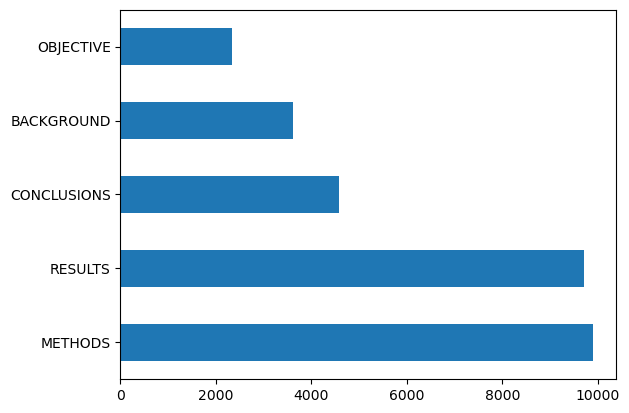

In [103]:
# sakinio etikečių pasiskirtymas test rinkinyje
test_df['target'].value_counts().plot.barh();

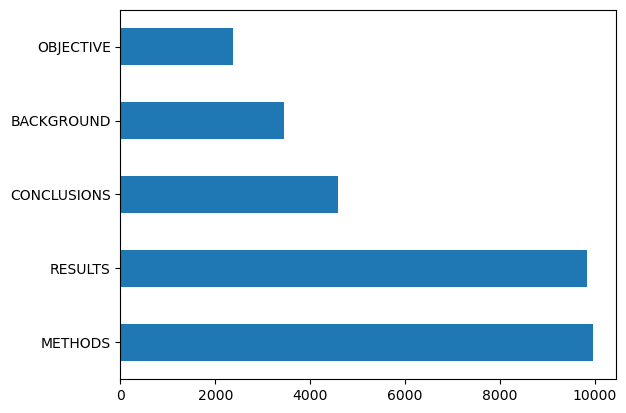

In [104]:
# sakinio etikečių pasiskirtymas val rinkinyje
val_df['target'].value_counts().plot.barh();

---

## Modelis 0: Bazinis modelis

**Bazinis modelis** - atskaitos taškas, su kuriuo lyginsime kitus modelius. Šis modelis mums padės įvertinti ar apsibrėžtai užduočiai reikia sudėtingesnio ANN modelio.

Remiantis [scikit-learn modelio parinkimo žemėlapiu](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) bazinių modelių buvo pasirinktas [daugianaris Naive Bayes klasifikatorius](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB), kuris apskaičiuos žodžio ar termino pasikartojimo konkrečios etiketės sakinyje tikimybę.

Kadangi klasifikuojame tekstą, jį reikia paversti skaitinėmis reikšmėmis. Tekstą transformuosime su [scikit-learn](https://scikit-learn.org) teksto savybių išskyrimo funkcija [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#), kuri retesniems terminams suteikia daugiau svarbos.

### Duomenų paruošimas

Baziniam modeliui naudosime santraukų sakinių tekstą (*text*) ir jų etikėtes kaip klasifikavimo klasės reikšmes (*target*).

In [105]:
# išskyriam santraukų sakinių tekstą
X_train = train_df["text"].to_list()
X_test = test_df["text"].to_list()
X_val = val_df["text"].to_list()

In [106]:
# išvedam pirmus penkis X_train sąrašo elementus
X_train[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

Mašininio mokymo modeliai tai pat reikalauja skaičiais išreikštų rezultato reikšmių, todėl sakinių etiketes konvertuosime į skaičius:
- su [scikit-learn](https://scikit-learn.org) funkcija [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
- su [scikit-learn](https://scikit-learn.org) funkcija [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [107]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [108]:
# konvertuojam etikečių reikšmes į skaičius su LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df["target"])
y_test = label_encoder.transform(test_df["target"])   
y_val = label_encoder.transform(val_df["target"])

In [109]:
# išedam pirmas 5 LabelEncoder užkuoduotas train etiketes
y_train[:5]

array([3, 2, 2, 2, 2])

In [110]:
# išsaugom etikėčių reikšmes
etiketes = label_encoder.classes_
etiketes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [111]:
# konvertuojam etikečių reikšmes į skaičius su OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

y_train_onehot = onehot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))   
y_val_onehot = onehot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))

In [112]:
# išedam pirmas 5 OneHotEncoder užkuoduotas train etiketes
y_train_onehot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Modelio kūrimas

Prieš perduodant duomenys į modelį juos reikia transformuoti, todėl teksto transformatorių ir klasifikatorių apjungiam panaudojant [scikit-learn](https://scikit-learn.org) klasės [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) objektą, kuriame nurodom, kokia eilės tvarka atlikti veiksmus.

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [114]:
# sukūriam bazinį modelį
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # teksto transformatorius
    ("clf", MultinomialNB())        # Naive Bayse dauginaris klasifikatorius
])

### Modelio mokymas

Bazinio modelio mokymui perduodame **train** rinkinio sakinių tekstą **X_train** ir skaičiais užkoduotas sakinių etikėtes **y_train**.

In [115]:
model_0.fit(X_train, y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Rezultatai

Klasifikacijos problemos sprendimas dažniausiai vertinamos pagal šiuos parametrus:
- **accuracy** - tikslumas, rodantis kiek klasifikacija yra arti tikrosios vertės
- **precision** - kiek iš visų "*true*" identifikuotų reikšmių ištikro yra "*true*"
- **recall** - kiek visų rinkinyje esančiu "*true*" reikšmių įdentifikuota teisingai
- **F1 score** - sunjungia *precision* ir *recall* į vieną vertę

In [116]:
accuracy = model_0.score(X_test, y_test)

In [117]:
# precision, recall ir F1 score įverčių skaičiavimui naudosime scikit-learn funkciją
from sklearn.metrics import precision_recall_fscore_support

y_pred = model_0.predict(X_test)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")


In [118]:
print("Bazinio modelio rezultatai:")
print(f"\taccuracy: \t{(accuracy * 100):.2f}%")
print(f"\tprecision: \t{(precision * 100):.2f}%")
print(f"\trecall: \t{(recall * 100):.2f}%")
print(f"\tF1 score: \t{(fscore * 100):.2f}%")

Bazinio modelio rezultatai:
	accuracy: 	71.67%
	precision: 	71.24%
	recall: 	71.67%
	F1 score: 	69.25%


><br>
>Pagal gautus rezultatus matome, kad mūsų bazinis modelis <b>~70% tikslumu</b> pritaiko teisingą sakinio etikėtę.<br>
><br>
>Reikia nepamiršti, kad bazinis modelis nekreipia dėmesio į sakinio vietą santraukoje, o klasifikuoja pagal dažniausiai pasitaikančius žodžius ar terminus.<br>
><br>

Sudarę sprendimų/sumaišties matricą (***angl. Confusion Matrix***) pamatysime kiek kartų kiekviena etikėtė buvo identifikuota teisingai ir kiek kartų supainioto su kitomis.

Confusion matrica sudarysime su [scikit-learn](https://scikit-learn.org) funkcija [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), atvaizduosime su klasės [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) objektu.

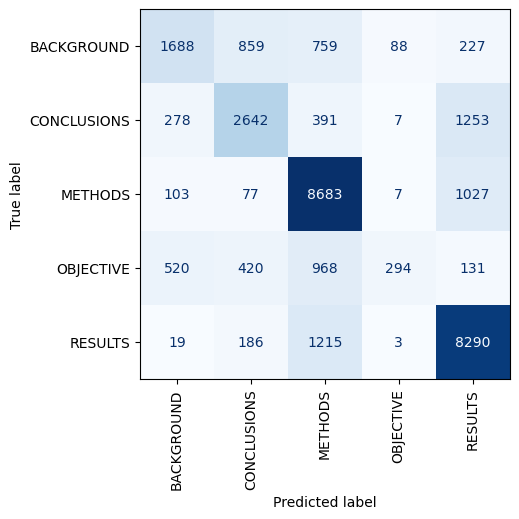

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_0_confusion_matrix = confusion_matrix(y_test, y_pred)
model_0_cm_plot = ConfusionMatrixDisplay(confusion_matrix=model_0_confusion_matrix, display_labels=etiketes)
model_0_cm_plot.plot(xticks_rotation="vertical", cmap="Blues", colorbar=False);
plt.show()

In [120]:
precisions, recalls, fscores, _ = precision_recall_fscore_support(y_test, y_pred)

In [121]:
# išvedam kiekvienos etikėtes klasifikavimo rezultatą
print(f"{'Label':12} | Precision | Recall | F1 score |")
print("-"*46)
for i, label in enumerate(etiketes):
    print(f"{label:12} | {(precisions[i]*100):9.2f} | {(recalls[i]*100):6.2f} | {(fscores[i]*100):8.2f} |")

Label        | Precision | Recall | F1 score |
----------------------------------------------
BACKGROUND   |     64.72 |  46.62 |    54.20 |
CONCLUSIONS  |     63.15 |  57.80 |    60.35 |
METHODS      |     72.26 |  87.73 |    79.25 |
OBJECTIVE    |     73.68 |  12.60 |    21.52 |
RESULTS      |     75.86 |  85.35 |    80.33 |


><br>
>Baziniam modeliui sunkiausiai sekasi identifikuoti OBJECTIVE etiketę, kuri dažniausiai identifikuojama kaip METHODS arba BACKGROUND.<br>
><br>
>Geriausiai sekasi identifikuoti RESULTS ir METHODS etiketes, kurios tarpusavyje dažniausiai ir maišomos.<br>
><br>
>Šį rezultatą lemia etikėte pažymėtų sakinių skaičius duomenų rinkinyje, t.y. žodžiai/terminai dažniausiai pasikartos tos etiketės sakiniuose, kurios sakinių daugiausia.<br>
><br>

---

## Modelis 1: Conv1D with token embedding

TensorFlow ANN modelį sudaris šie sluoksniai:
1. **Input** - įvedimo sluoksnis, kuriam perduodamas santraukos sakinio tekstas ir etiketė
2. **TextVectorizer** - sužymi sakinio žodžius sveikais skaičiais, pagal iš anksto sudarytą žodžių (*token*) žodyną
3. **Embedding** - paverčia kiekvieną sveiku skaičiumi pažymėtą sakinio žodį nurodyto fiksuoto dydžio vekoriumi
4. **Conv1D** - atlieka vienmatę konvoliuciją pagal nurodyto dydžio langą (*kernel*)
5. **GlobalAveragePooling1D** - sutankina Conv1D rezultata, grąžindamas vidurkių vektorių
6. **Dense** - išvedimo sluoknis, grąžina kiekvienos etikėtės tikimybę

 ### Duomenų paruošimas TensorFlow modeliams

**Tokenization** yra žodžių, skaičių simbolių ir (arba) skyrybos ženklų pavertimas sveikais skaičiais. Šio proceso metu yra sudaromas nurodyto dydžio žodynas, kuriame žodis (*token*) susiejamas su skaičiumi, žodžiai rikiuojami mažėjimo tvarka nuo dažniausiai pasikartojančio.

**Embedding** proceso metu sveiki token'ų skaičiai paverčiami fiksuoto dydžio vektoriais.

Santraukų sakinių vektorizacija atliksime su [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) sluoksniu, kuriam nurodysime pageidaujamo tokenizacijos žodyno dydį bei vektorizuoto santraukos sakinio ilgį. Todėl pirmiausia turime išsiaiškinti kokio vdutiniškai ilgio yra santraukų sakiniai bei kiek skirtingų žodžių yra naudojamo rinkinio santraukose.

In [122]:
# randam santraukų sakinių ilgių vidurkį bei ilgiausio sakinio ilgį X_train rinkinyje
sentence_lens = [len(sentence.split()) for sentence in X_train] # sudarom sakinių ilgių sąrašą
avg_sentence_len = int(np.mean(sentence_lens)) # vidutinis žodžių skaičius sakinyje
max_sentence_len = np.max(sentence_lens) # ilgiausio sakinio žodžių skaičius

print(f"Sakinių ilgių vidurkis: {avg_sentence_len} žodžiai")
print(f"Ilgiausias sakinys: {max_sentence_len} žodžiai")

Sakinių ilgių vidurkis: 26 žodžiai
Ilgiausias sakinys: 296 žodžiai


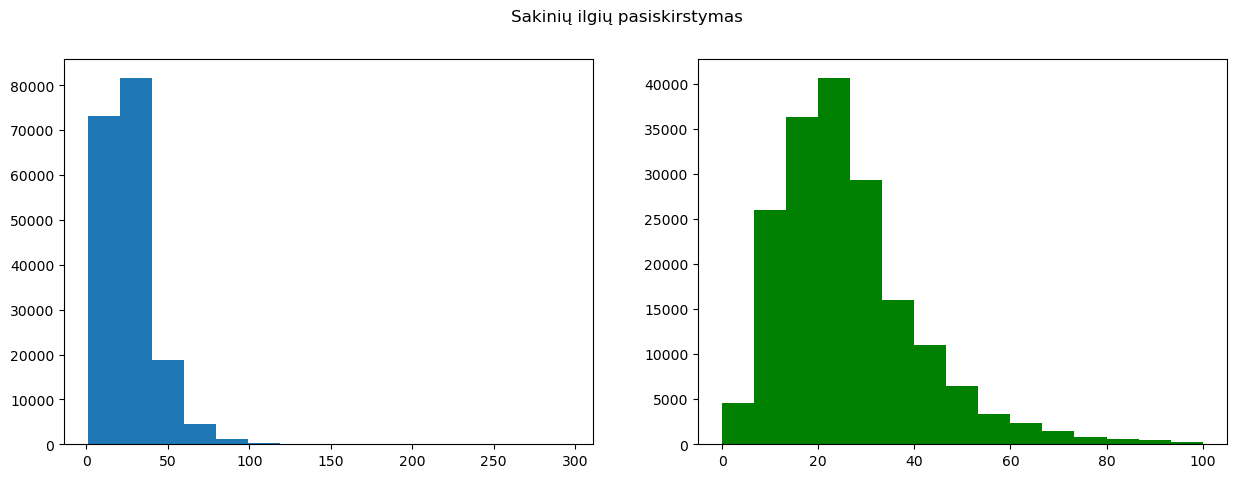

In [123]:
# atvaizduojam sakinių ilgių pasiskirstymą su histograma
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Sakinių ilgių pasiskirstymas")

ax[0].hist(sentence_lens, bins=15)
ax[1].hist(sentence_lens, bins=15, range=[0, 100], facecolor='green', align='mid')

plt.show()

In [124]:
# randam kokio maksimalaus ilgio yra 95% visų sakinių
output_sentence_len = int(np.percentile(sentence_lens, 95))
print(f"Maksimalus sakinių ilgis tarp 95% visų sakinių: {output_sentence_len} žodžiai")

Maksimalus sakinių ilgis tarp 95% visų sakinių: 55 žodžiai


#### Sakinių teksto vektorizacija

Atlikti santraukų sakinių teksto vektorizacijai papildomai reikia visų skirtingų žodžių skaičiaus, šis skaičius nurodytas duomenų rinkinio [**PubMed 200k RCT**](https://arxiv.org/pdf/1710.06071.pdf) aprašymo antroje lentelėje.

Rinkinio **PubMed_20k_RCT** žodyną sudaro **68 tūkst.** žodžių.

In [125]:
# nurodom maksimalu duomenų rinkinio žodyno dydį
max_tokens = 68000

# sukuriam vektorizavimo sluoksnį
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                           output_sequence_length=output_sentence_len)

# sukuriam tokenizacijos žodyną naudojant X_train sakinius
text_vectorizer.adapt(X_train)

In [126]:
# patikrinam teksto sakinių vektorizaciją su pasirinktu sakiniu
test_sentence = X_train[2]

print(f"Originalus sakinio tekstas:\n{test_sentence}\n")
print(f"Vektorizuotas sakinio tekstas:\n{text_vectorizer([test_sentence])}")

Originalus sakinio tekstas:
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

Vektorizuotas sakinio tekstas:
[[ 86 213 121  65 169   3 194   5 149 119   3 670 636 747   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [127]:
# tokenizacijos metu sudaryto žodyno apžvalga
tokens_vocabulary = text_vectorizer.get_vocabulary()

print(f"Žodžių skaičius žodyne: {len(tokens_vocabulary)}")
print(f"Dažniausi žodžiai: {tokens_vocabulary[:10]}")
print(f"Rečiausi žodžiai: {tokens_vocabulary[-10:]}")

Žodžių skaičius žodyne: 64841
Dažniausi žodžiai: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Rečiausi žodžiai: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Tokenizuotų sakinių embedding'as

In [128]:
#  sukuriam žodžių embedding'o sluoksnį
token_embedder = layers.Embedding(input_dim=len(tokens_vocabulary),
                                  output_dim=128, # rezultato vektoriaus dydis
                                  mask_zero=True, # paslepiam vektorizuoto sakinio tuščias reikšmes
                                  name="token_embedding")

In [129]:
# patikrinam sakinio teksto vektorizaciją kartu su token'ų embedding'u
original_sentence = X_train[2]
print(f"Originalus sakinio tekstas:\n{original_sentence}")

vectorized_sentence = text_vectorizer([original_sentence])
print(f"\nVektorizuotas sakinio tekstas:\n{vectorized_sentence}")

embedded_sentence = token_embedder(vectorized_sentence)
print(f"\nEmbedded sakinio tekstas:\n{embedded_sentence}")

print(f"\nVektorizuoto sakinio formatas: {vectorized_sentence.shape}")
print(f"Embedded sakinio formatas: {embedded_sentence.shape}")

Originalus sakinio tekstas:
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

Vektorizuotas sakinio tekstas:
[[ 86 213 121  65 169   3 194   5 149 119   3 670 636 747   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Embedded sakinio tekstas:
[[[-0.02378225 -0.01584622 -0.03734333 ... -0.01774526 -0.03539606
   -0.02622596]
  [-0.01333358 -0.01889094 -0.00517968 ... -0.00881302 -0.02264233
    0.04537034]
  [ 0.02113721  0.00304519  0.02246613 ...  0.02451083  0.02441904
   -0.01475458]
  ...
  [-0.00574837 -0.00880262 -0.02187747 ... -0.01899239 -0.03823622
   -0.01525575]
  [-0.00574837 -0.00880262 -0.02187747 ... -0.01899239 -0.03823622
   -0.01525575]
  [-0.00574837 -0.00880262 -0.02187747 ... -0.01899239 -0.03823622
   -0.01525575]]]

Vektorizuoto sakinio formatas: (1, 55)
Embedded sakinio formatas

#### TensorFlow Dataset sudarymas

**GPU** ir **TPU** gali drastiškai sutrumpinti laiką, reikalingą vienam mokymo žingsniui atlikti. [tf.data](https://www.tensorflow.org/guide/data) API padeda sukurti efektyvias duomenų struktūras, kuriomis duomenys kitam veiksmui perduodami dar nepasibaigus dabartiniam.

Santraukų sakinius ir *One Hot* koduotas etiketes sujungiam su **TesorFlow Dataset** metodu [from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices). Sudarytus *Dataset* rinkinius suskirstom į **paketus po 32** pavyzdžius naudojant [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), papildmai su [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) nurodysim paruošti vėlesnius duomenis, kol apdorojamas dabartinis.

In [130]:
# turimus duomenis perkėliam į TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_onehot))

In [131]:
# suskirstom duomenis į paketus po 32 pavyzdžius
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [132]:
# patikrinam sudarytus duomenų rinkinius
train_dataset, test_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Modelio sudarymas

In [133]:
# aprašom modelio sluoksnius
inputs = layers.Input(shape=(1,), dtype=tf.string) # įvedimo sluoksnis

# duomenų apdorojimo sluoksniai
text_vectors = text_vectorizer(inputs) # vektorizuojam įvedimą
token_embeddings = token_embedder(text_vectors) # embeddinam vektorizuotus sakinius

# atliekam vienmatę konvoliuciją naudojant 5 reikšmių branduolį (langą) ir sutankinam rezultatus
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(units=len(etiketes), activation="softmax")(x) # išvedimo sluoksnis

# aprašom modelį, nurodydami įvedimo ir išvedimo sluoksnius
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [134]:
# sukūriam (kompiliuojam) aprašytą modelį
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [135]:
# išvedam sudaryto modelio struktūra
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [136]:
# modelio diagramos sudarymas
# from keras.utils import plot_model
# plot_model(model_1, show_shapes=True)

### Modelio mokymas

In [137]:
# atliekam modelio mokinimą naudojant tik 10% duomenų paketų (batches)
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)),
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir="tensorboard")])

Epoch 1/5
562/562 [==============================] - 17s 29ms/step - loss: 0.9142 - accuracy: 0.6365 - val_loss: 0.6825 - val_accuracy: 0.7430
Epoch 2/5
562/562 [==============================] - 5s 10ms/step - loss: 0.6521 - accuracy: 0.7589 - val_loss: 0.6272 - val_accuracy: 0.7753
Epoch 3/5
562/562 [==============================] - 4s 8ms/step - loss: 0.6120 - accuracy: 0.7759 - val_loss: 0.5904 - val_accuracy: 0.7872
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5851 - accuracy: 0.7913 - val_loss: 0.5745 - val_accuracy: 0.7886
Epoch 5/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5881 - accuracy: 0.7920 - val_loss: 0.5591 - val_accuracy: 0.7962


### Modelio vertinimas

Šį ir kitus TensorFlow modelius vertinsim pagal šiais etapais:
1. Mokinimo (*training*) ir įvetinimo (*validation*) tisklumų (*accuracy*) ir praradimų (*loss*) kreivių palyginimas
2. Modelio tikslumo įvertinimas su testavimo (*test_dataset*) duomenimis
3. Klasifikacijos įvertinimas su testavimo (*test_dataset*) duomenimis (*precision, recall, F1 Score*)

Todėl prieš atliekant "Modelis 1" vertinimą paruošime pagalbines funkcijas, kurias naudosim vertinant kitus modelius:
- **plot_accuracy_loss_curves** - mokymo ir įvertinimo praradimo (loss) bei tikslumo kreivių palyginimą
- **print_classification_results** - klasifikacijos įverčių spausdinimas

In [138]:
def plot_accuracy_loss_curves(history, model_name):
    """
    Grąžina mokymo ir įvertinimo praradimo (loss) ir tikslumo kreivių palyginimą

    Args:
        history: TensorFlow modelio History objektas, gaunamas mokinant modelį
        model_name: modelio pavadinimas
    """

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(history.history['loss'])+1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Modelio '{model_name}' mokinimo ir įvertinimo rezultatai")

    # tikslumo (accuracy) palyginimas
    ax[0].plot(epochs, train_accuracy)
    ax[0].plot(epochs, val_accuracy)
    ax[0].legend(['mokinimas', 'įvertinimas'], loc='upper left')
    ax[0].set_title("Tikslumų palyginimas")
    ax[0].set_xlabel("Epochos")
    ax[0].set_ylabel("Tikslumas")
    
    # praradimų (loss) palyginimas
    ax[1].plot(epochs, train_loss, label='training_loss')
    ax[1].plot(epochs, val_loss, label='val_loss')
    ax[1].legend(['mokinimas', 'įvertinima'], loc='upper right')
    ax[1].set_title("Praradimų (loss) palyginimas")
    ax[1].set_xlabel("Epochos")
    ax[1].set_ylabel("Praradimas")

    plt.show()

In [139]:
def print_classification_results(y_true, y_pred, model_name):
    """
    Spausdina klasifikacijos įverčius precision, recall, F1 score

    Args:
        y_true: teisingos reikšmės
        y_pred: modelio spėtos reikšmės
        model_name: modelio pavadinimas
    """

    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    f1score = 2 * ((precision*recall) / (precision + recall))
    
    precision.update_state(y_true, y_pred).results().numpy()
    recall.update_state(y_true, y_pred).results().numpy()

    print(f"Modelio '{model_name}' klasifikacijos rezultatai:")
    print(f"\tPrecision: {(precision*100):.2f}%")
    print(f"\tRecall: {(recall*100):.2f}%")
    print(f"\tF1 score: {(f1score*100):.2f}%")

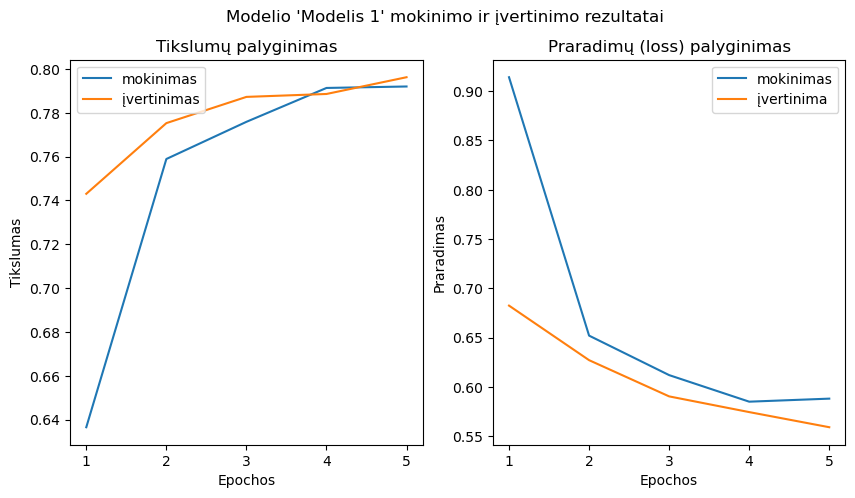

In [140]:
# sudarom modelio "Modelis 1" vertinimo diagramas
plot_accuracy_loss_curves(model_1_history, "Modelis 1")

In [143]:
# įvertinam modelį su visais vertinimo rinkinio pavyzdžiais
loss, accuracy = model_1.evaluate(test_dataset)
print(f"Modelio 'Modelis 1' tikslumas su testavimo duomenimis: {(accuracy*100):.2f}%")

942/942 [==============================] - 3s 3ms/step - loss: 0.5728 - accuracy: 0.7958
Modelio 'Modelis 1' tikslumas su testavimo duomenimis: 79.58%
